In [1]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')

In [2]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data

import torch
import PIL.ImageOps

In [3]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load dataset

In [4]:
transformations = [tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                   tfs.Resize((128,128)),]
                   #tfs.Grayscale(1),
                   #tfs.Lambda(lambda x: PIL.ImageOps.invert(x))]

imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=True)

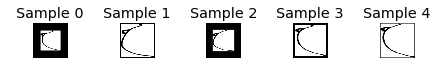

In [5]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    #print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]), cmap=plt.cm.gray_r)
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Process type of vessels for classification

In [6]:
df = utils.create_df_from_files(path='data/perfiles_CATA/clases/')

#### Build and train classifier

In [7]:
imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                           tfs.Resize((128, 128)),
                                                           #tfs.Resize(128),
                                                           #tfs.Grayscale(1),
                                                           #tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                                           tfs.ToTensor()]))
                                                           #tfs.Normalize((0.5,), (0.5,))]))


In [8]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)

In [9]:
splits_len = splits_len if np.sum(splits_len) == len(imagenet_data.samples) else splits_len[0], splits_len[1], splits_len[2]+1

In [10]:
splits_len

(256, 128, 898)

#### Random split

In [11]:
splits = utils.random_split(imagenet_data, splits_len)

In [12]:
splits[0].dataset

Dataset ImageFolder
    Number of datapoints: 1282
    Root Location: data/perfiles_CATA/png_clasificados/
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.7)
                             RandomAffine(degrees=(0, 0), scale=(0.7, 1.0))
                             Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None

In [13]:
splits[0].indices

tensor([ 559, 1248,  165,  379, 1156,  274, 1252,  380,  994,  329,  968,  991,
         403,  103,  409,  157,  445,  538,  847,  982,  796,  372,  632,  830,
         377,   64,  878,  473,  246,  340,  653,  684,  324,  116,  986,  816,
        1257,  264,   67,   41,  229,  496, 1052,  315, 1194,  724, 1134,  261,
         802,  365,  212,  339, 1048,  773,  501,  885,  516,  217,  971,  799,
          88,  331,  899, 1132,  179,  337,  545, 1003,  408, 1009,  967,  894,
         254,   31,  688,  671,  879,  547,  873,  421,  850, 1075,  670,  272,
          53,  234, 1161,  752,  617,  786,  311,  783,   20,  619,  317,  975,
         886,  457,  962, 1171,  203,  791, 1234, 1090, 1216,  812,  495,  238,
        1092,  827,  810,  218,  593,  173,  597,  484,  540,  204,  731,    0,
         770,  728,  639,  512,  711,  595,  576,  818,  881,  609,   86, 1060,
        1231,  522,  127,  260, 1025, 1104,  936, 1107, 1024,  615,  488,   40,
         205,  349,   87,  590, 1255,  2

In [14]:
import pickle

In [15]:
#filehandler = open("data_pickle/indice_0.pickle", 'wb') 
#pickle.dump(splits[0].indices, filehandler)
#filehandler = open("data_pickle/indice_1.pickle", 'wb') 
#pickle.dump(splits[2].indices, filehandler)

In [16]:
file_pi2 = open('data_pickle/indice_0.pickle', 'rb') 
splits[0].indices = pickle.load(file_pi2)

file_pi2 = open('data_pickle/indice_1.pickle', 'rb') 
splits[2].indices = pickle.load(file_pi2)

In [17]:
train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=True)
val_loader = data.DataLoader(splits[1], batch_size=32, shuffle=True)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=True)

In [18]:
import torch.optim as optim
from torch import nn
from models.classifierResnet import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import TopKCategoricalAccuracy, Loss
from ignite.handlers import ModelCheckpoint
import torch.nn.functional as F

In [19]:
C =_C(input_h_w=128)
C = C.to(available_device)
criterion = nn.CrossEntropyLoss().to(available_device)
C_optimizer = optim.Adam(C.parameters(), lr=0.0002, betas=(0.5, 0.999))

vis = visdom.Visdom(port='8090')
log_interval = 10
trainer = create_supervised_trainer(C, C_optimizer, F.cross_entropy, device=available_device)

handler_checkpoint = ModelCheckpoint('models/checkpoint_data_resnet', 'cnn_vessels', save_interval=2, n_saved=2, create_dir=True, require_empty=False, save_as_state_dict=True)
trainer.add_event_handler(Events.EPOCH_COMPLETED, handler_checkpoint, {'model': C, 'optimizer': C_optimizer})


evaluator = create_supervised_evaluator(C, metrics={'accuracy': TopKCategoricalAccuracy(),
                                                     'ce_ll': Loss(F.cross_entropy)},
                                           device=available_device)


train_avg_loss_window = utils.create_plot_window(vis, '#Iterations', 'Loss', 
                                                 'Training Average Loss')
train_avg_accuracy_window = utils.create_plot_window(vis, '#Iterations', 'Accuracy',
                                                     'Training Average Accuracy')
val_avg_loss_window = utils.create_plot_window(vis, '#Epochs', 'Loss',
                                               'Validation Average Loss')
val_avg_accuracy_window = utils.create_plot_window(vis, '#Epochs', 'Accuracy',
                                                   'Validation Average Accuracy')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
             win=train_avg_accuracy_window, update='append')
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
             win=train_avg_loss_window, update='append')

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
             win=val_avg_accuracy_window, update='append')
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
             win=val_avg_loss_window, update='append')

trainer.run(train_loader, max_epochs=100)

Training Results - Epoch: 1  Avg accuracy: 0.85 Avg loss: 1.76
Validation Results - Epoch: 1  Avg accuracy: 0.85 Avg loss: 1.85
Training Results - Epoch: 2  Avg accuracy: 0.97 Avg loss: 1.24
Validation Results - Epoch: 2  Avg accuracy: 0.95 Avg loss: 1.38
Training Results - Epoch: 3  Avg accuracy: 1.00 Avg loss: 0.52
Validation Results - Epoch: 3  Avg accuracy: 0.99 Avg loss: 0.60
Training Results - Epoch: 4  Avg accuracy: 1.00 Avg loss: 0.46
Validation Results - Epoch: 4  Avg accuracy: 1.00 Avg loss: 0.57
Training Results - Epoch: 5  Avg accuracy: 0.90 Avg loss: 2.64
Validation Results - Epoch: 5  Avg accuracy: 0.87 Avg loss: 3.18
Training Results - Epoch: 6  Avg accuracy: 0.98 Avg loss: 0.50
Validation Results - Epoch: 6  Avg accuracy: 0.98 Avg loss: 0.46
Training Results - Epoch: 7  Avg accuracy: 0.99 Avg loss: 0.32
Validation Results - Epoch: 7  Avg accuracy: 0.99 Avg loss: 0.44
Training Results - Epoch: 8  Avg accuracy: 0.95 Avg loss: 0.92
Validation Results - Epoch: 8  Avg accura

In [20]:
from torchsummary import summary
if available_device == "cuda":
    summary(C, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

### Confusion matrix and classification report

In [23]:
import torchnet

confusion_window = utils.create_plot_window(vis, 'True Labels', 'Predicted', 'Confusion Matrix')

confusion_matrix = torchnet.meter.ConfusionMeter(11, normalized=True)
for ii, data_ in enumerate(test_loader):
    input_, label = data_
    val_input = Variable(input_).to(available_device)
    val_label = Variable(label.type(torch.LongTensor)).to(available_device)
    score = C(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))
    
np.set_printoptions(precision=3)
print(confusion_matrix.value())
print(confusion_matrix.conf)
vis.heatmap(confusion_matrix.value(), win=confusion_window)

AssertionError: number of predictions does not match size of confusion matrix

In [24]:
from sklearn import metrics

def iterations_test(C, test_loader):
    y_real = list()
    y_pred = list()

    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = C(val_input)
        _, y_pred_batch = torch.max(score, 1)
        y_pred_batch = y_pred_batch.cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

In [25]:
y_real, y_pred = iterations_test(C, test_loader)
print(metrics.classification_report(np.array(y_pred), np.array(y_real)))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.99      1.00      0.99        76
           2       1.00      0.97      0.98        31
           3       0.80      0.89      0.84         9
           4       0.88      0.88      0.88        17
           5       1.00      0.67      0.80         3
           6       1.00      0.89      0.94         9
           7       0.60      1.00      0.75         6
           8       0.89      1.00      0.94         8
           9       0.96      0.94      0.95        78
          10       1.00      0.83      0.91         6

   micro avg       0.95      0.95      0.95       256
   macro avg       0.92      0.91      0.90       256
weighted avg       0.96      0.95      0.95       256



In [26]:
avg_acc = list()
for i in range(5):
    y_real, y_pred = iterations_test(C, test_loader)
    avg_acc.append(metrics.accuracy_score(np.array(y_pred), np.array(y_real)))
print(np.mean(avg_acc), avg_acc)

0.94453125 [0.9453125, 0.94140625, 0.94921875, 0.94140625, 0.9453125]
